# Feature Selection
(by Tevfik Aytekin)

In feature election we try to find relevant features, that is, features which have an influence on the output. We will also try to quantify the influence of a feature. There are several ways we can find the relevance of features, in this notebook we will look at univariate filter methods. In other words, we will try to find the relevance of a single feature (independent of the others) on the output.


In [69]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.utils import resample
from scipy.stats import chisquare
from sklearn.feature_selection import chi2, SelectKBest, f_classif, f_regression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from scipy.stats import chi2
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif
from sklearn import feature_selection



### Univariate Feature Selection
We will look at the pairwise relationships between the output variable and each one of the input variables. Our aim is to understand whether these pairs of variables are independent of each other or there is some kind of relationship between them. Different from visualizations, we will generate a numerical value for measuring the strength of the relationship.

We will use the following two datasets for illustration.
#### Example Datasets

In [2]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
bank.shape

(45211, 17)

In [3]:
# list random rows from the dataset
bank.iloc[np.random.randint(1,bank.shape[0],10),:] 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
20359,53,self-employed,married,primary,no,2639,no,no,cellular,11,aug,304,4,-1,0,unknown,no
23673,33,management,single,tertiary,no,755,yes,no,cellular,28,aug,68,12,-1,0,unknown,no
38146,28,technician,married,secondary,no,916,yes,no,cellular,15,may,191,1,371,2,other,no
10571,38,technician,single,tertiary,no,38,no,no,unknown,16,jun,64,1,-1,0,unknown,no
26135,53,entrepreneur,married,primary,no,1034,yes,no,cellular,19,nov,854,2,170,3,other,no
20307,53,management,divorced,secondary,no,112,no,yes,cellular,11,aug,246,3,-1,0,unknown,no
30073,43,technician,married,secondary,no,0,yes,yes,cellular,4,feb,539,8,204,5,failure,no
12731,37,entrepreneur,married,tertiary,no,555,no,no,cellular,7,jul,104,2,-1,0,unknown,no
39317,24,blue-collar,single,secondary,no,5482,yes,no,cellular,18,may,424,2,-1,0,unknown,no
4597,32,blue-collar,married,primary,no,8291,no,no,unknown,20,may,131,1,-1,0,unknown,no


In [4]:
# load train.csv file from Kaggle "House Prices: Advanced Regression Techniques" dataset 
house = pd.read_csv("../datasets/house_prices/train.csv")
# print first 5 examples
house.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Case 1: Numerical Input vs. Numeric Output

For this type of analysis a common technique is to look at the correlation between the variables. There are three commonly used correlation measures: Pearson, Spearman, and Kendall. We will look at each in turn.


### Pearson correlation

Pearson correlation is a measure of linear relationship between two random variables X and Y. It is a scaled version of covariance (between -1 and 1); note that the two parameters always have the same sign (positive, negative, or 0). When the sign is positive, the variables are said to be positively correlated; when the sign is negative, the variables are said to be negatively correlated; and when the sign is 0, the variables are said to be uncorrelated. For basic statistical concepts like variance, covariance, and standard deviation check this [notebook](stats.ipynb).

$$pcorr(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

(0.9874100874179736, 7.282637065765987e-07)

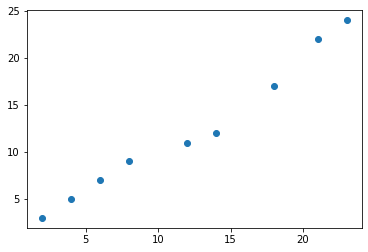

In [5]:
# Example
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 12, 17, 22, 24]

plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

### A note on p-value

p-value is an important statistical concept used in hypothesis testing. Technically, the p-value is the probability of observing a test statistic that is as extreme or more extreme than the observed test statistic under the null hypothesis. Intiutively, it means how likely it is to observe the sample by chance. If the p-value is small (typically less then 0.05) then we can reject the null hypothesis, that is, we can conclude that its very unlikely to observe the sample by chance.

For Pearson correlation the null hypothesis is that the samples come from uncorrelated normal distributed populations.

p-values are important when the sample sizes are small. Check out the sample below, the correlation is high but p-value > 0.05 which implies that the samples might come from uncorrelated populations. As a rule of thumb, you should ignore correlations which are not statistically significant (p > 0.05) even if the correlation is high.

(0.8944271909999159, 0.10557280900008414)

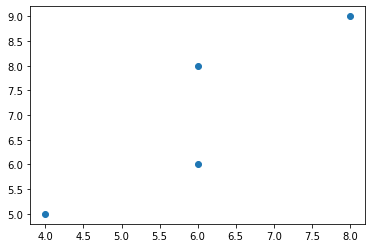

In [6]:
# Example
X = [6, 4, 6, 8] 
Y = [6, 5, 8, 9] 
plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

Below are some example datases with various degrees of Pearson correlation.

Question: Note that there is no correlation coefficient value for the dataset in the middle position. Why is that? Hint: Check the definition of correlation.

[image source](http://commons.wikimedia.org/wiki/File:Correlation_examples2.svg)

<img src="images/cor1.png" alt="drawing" width="500" align="left">


### <center>Anscombe's Quartet</center>

For all four datasets below the Pearson correlation coefficient is: +0.816.

<img src="images/cor2.png" alt="drawing" width="500" align="left">  


[image source](http://commons.wikimedia.org/wiki/File:Anscombe%27s_quartet_3.svg)  


#### Outlier Problem

Outliers might dratically influence the correlation values, so one should be careful with outliers in the evaluation of correlation results.

(0.0020896678072882535, 0.9957429791908522)

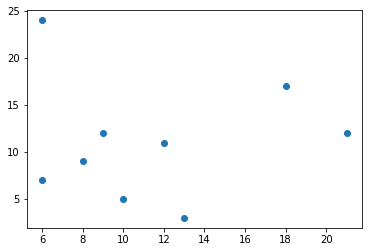

In [7]:
# Example
X = [13, 10, 6, 8, 12, 9, 18, 21, 6]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

(0.9632125532618062, 7.664333701501002e-06)

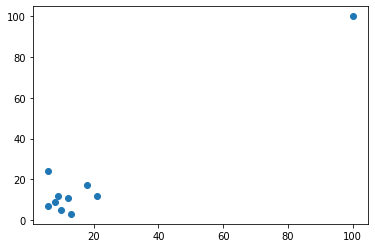

In [8]:
# After adding a single outlier
X = [13, 10, 6, 8, 12, 9, 18, 21, 6, 100]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24, 100]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

### Spearman rank correlation
Spearman rank correlation is the Pearson correlation between the rank values of two variables.

<img src="images/spearman.png" style="max-width:100%; width: 40%" align="left">

[image source](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/600px-Spearman_fig1.svg.png)

SpearmanrResult(correlation=1.0, pvalue=0.0)

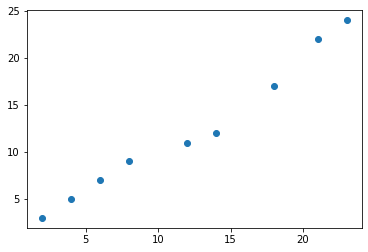

In [9]:
# Example
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 12, 17, 22, 24]

plt.plot(X,Y, "o")
stats.spearmanr(X,Y)

In [10]:
print(stats.rankdata(X))
print(stats.rankdata(Y))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


SpearmanrResult(correlation=0.9833333333333333, pvalue=1.9361963037459243e-06)

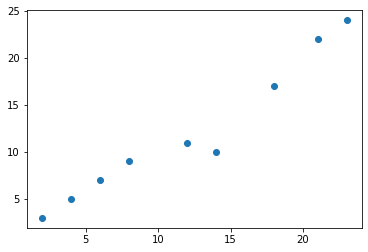

In [11]:
# Let us change the example a little
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 10, 17, 22, 24]

plt.plot(X,Y, "o")
stats.spearmanr(X,Y)

In [12]:
X_ranks = stats.rankdata(X)
Y_ranks = stats.rankdata(Y)
print(X_ranks); print(Y_ranks)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1. 2. 3. 4. 6. 5. 7. 8. 9.]


In [13]:
stats.pearsonr(X_ranks,Y_ranks)

(0.9833333333333333, 1.936196303745927e-06)

### Kendall Rank Correlation

In [14]:
def kendall_tau_T(x,y):
    concordant = 0
    discordant = 0
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if ((x[i]-x[j]) * (y[i]-y[j])) > 0:
                concordant += 1
            else:
                discordant += 1
    return (concordant-discordant)/(concordant+discordant)

KendalltauResult(correlation=0.7777777777777777, pvalue=0.0009463183421516755)

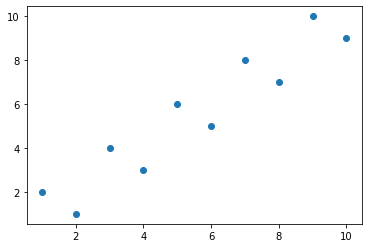

In [15]:
X = [1,2,3,4,5,6,7,8,9,10]
Y = [2,1,4,3,6,5,8,7,10,9]
plt.plot(X,Y, "o")
stats.kendalltau(X,Y)

In [17]:
kendall_tau_T(X,Y)

0.7777777777777778

# Case 2: Numerical Input vs. Categorical Output


Now we will try to see if a numerical feature is relevant for a categorical class variable. One thing we can do is to look at the distribution of the numerical variable grouped by each value of the categorical variable. If the categorical and numerical variables are independent then we expect to see a similar distribution of the values of the numerical variable for each value of the categorical variable (i.e., the grouping of the numerical variable by the values of the categorical variable should not create any difference). But if the distributions are not similar then we may say that the numerical variable is relevant and also as the dissimilarity of the distributions increase it is reasonable to assume that the relevancy also increases. Of course we need some formula to measure similarity of distributions. Note that there can be two or more distributions. So our measure should work for two or more distributions. One such measure is Anova F-value.

F-statistic is a way of measuring the difference between sample distributions which is defined below. Further below you will find the implementation.

$$ F = \frac{Variation\: between\: sample\: means}{Variation\: within\: the\: samples} $$


**Look at the following figures and try to answer this question: are these groups come from the same population or not? How can we measure this probability, that is, the probability of coming form the same distribution?**

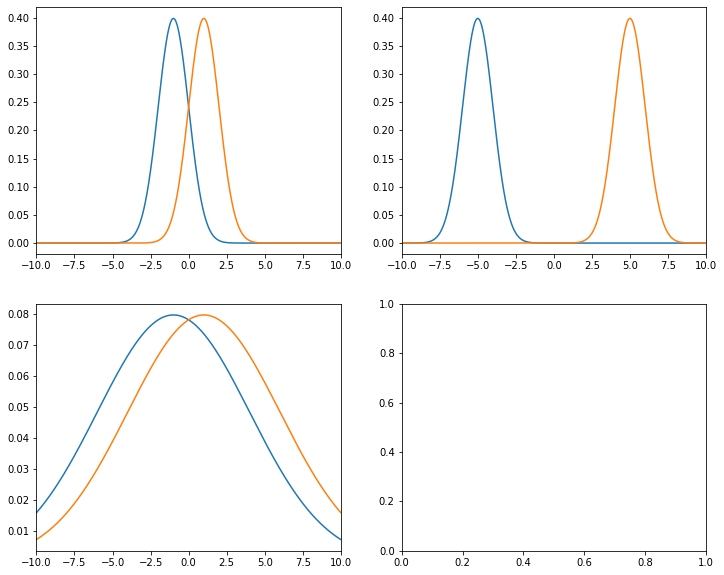

In [18]:
f, ax = plt.subplots(2,2)
ax[0,0].set_xlim(-10,10)
f.set_size_inches(12,10)

x = np.arange(-10, 10, 0.01)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,1), ax= ax[0,0])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,1), ax= ax[0,0])

ax[0,1].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-5,1), ax= ax[0,1])
sns.lineplot(x=x, y=stats.norm.pdf(x,5,1), ax= ax[0,1])

ax[1,0].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,5), ax= ax[1,0])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,5), ax= ax[1,0])


# Mean = 0, Std = 2. You can play wth these parameters.


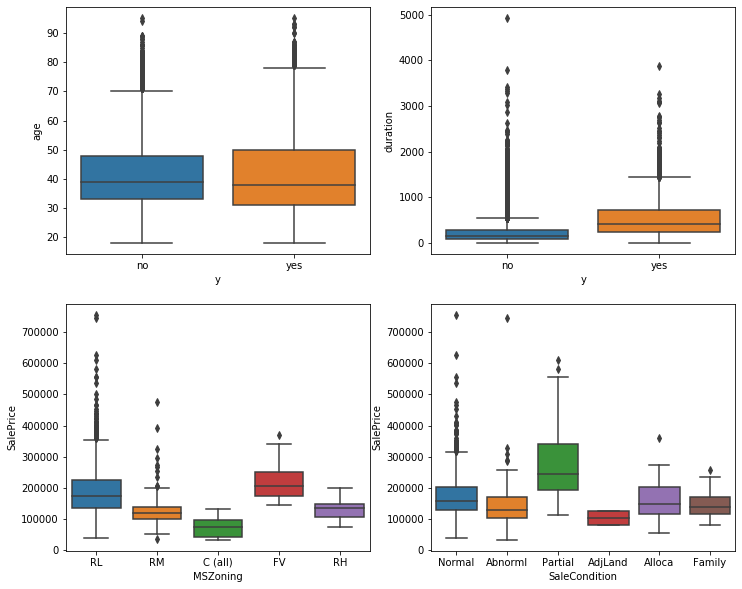

In [19]:
f, ax = plt.subplots(2,2)
f.set_size_inches(12,10)
sns.boxplot(y="age", x="y", data= bank, ax = ax[0,0]);
sns.boxplot(y="duration", x="y", data= bank, ax = ax[0,1]);
sns.boxplot(x="MSZoning", y="SalePrice", data= house, ax = ax[1,0]);
sns.boxplot(x="SaleCondition", y="SalePrice", data= house, ax = ax[1,1]);


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf5ca72b50>,
      dtype=object)

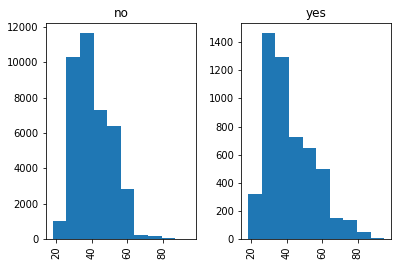

In [20]:
bank["age"].hist(by=bank["y"])

Below is the result of one-way anova test. As can be seen the result is statistically significant, so smaller age indeeds affects the result in the positive way, however, what is the size of this affect?


In [21]:
group1 = bank[bank["y"]=="yes"].age
group2 = bank[bank["y"]=="no"].age
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)


28.625233091728465 8.825643691900577e-08


Let us calculate the f-value from scratch.

In [22]:
def f_statistic_T(*groups):
    
    merged_groups = np.concatenate(groups)
    grand_mean = np.mean(merged_groups)
    group_means = [np.mean(g) for g in groups]
    ss_within = 0
    ss_between = 0
    for i in range(len(groups)):
        ss_within += np.sum((groups[i] - group_means[i])**2)
        ss_between += groups[i].size * (group_means[i] - grand_mean)**2
        
    df1 = len(groups) - 1
    df2 = merged_groups.size - len(groups)
    f_stat = (ss_between / df1) / (ss_within / df2)
    
    #print(ss_between / df1)
    #print(ss_within / df2)
    #print(ss_total," ",ss_within," ", ss_between)
    #print(ss_within + ss_between)
    #print(f_statistic)
    
    return f_stat

An example step by step

In [23]:
groups = [[1,2,3,4,5],[3,4,5,6,7]]
merged_groups = np.concatenate(groups)
grand_mean = np.mean(merged_groups)
print("grand mean",grand_mean)
group_means = [np.mean(g) for g in groups]
print("group means", group_means)

grand mean 4.0
group means [3.0, 5.0]


In [24]:
i=0
(groups[i] - group_means[i])**2

array([4., 1., 0., 1., 4.])

In [26]:
group1 = bank[bank["y"]=="yes"].age.values
group2 = bank[bank["y"]=="no"].age.values
f_statistic_T(group1, group2)


28.62523309172829

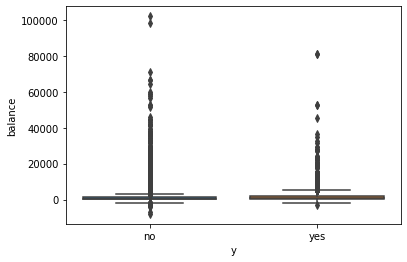

In [27]:
sns.boxplot(y="balance", x="y", data= bank);

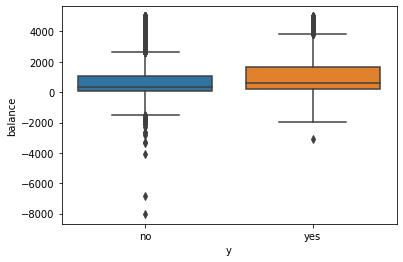

In [28]:
bank2 = bank[(bank.balance < 5000)]
sns.boxplot(y="balance", x="y", data= bank2);

In [29]:
group1 = bank[bank["y"]=="yes"].balance
group2 = bank[bank["y"]=="no"].balance
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

126.57227551143087 2.5211136918594683e-29


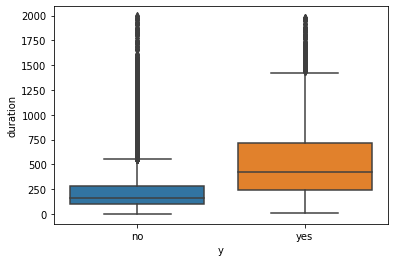

In [30]:
bank2 = bank[(bank.duration < 2000)]
sns.boxplot(y="duration", x="y", data= bank2);

In [31]:
group1 = bank[bank["y"]=="yes"].duration
group2 = bank[bank["y"]=="no"].duration
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

8333.761148332413 0.0


### SelectKBest

We can use SelectKBest to find features with the highest scores.

In [32]:
X = bank.loc[:,'age':'poutcome']
X = bank.select_dtypes(include=np.number) # select numeric columns

y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,-1])
selector = SelectKBest(f_classif, k=7)
selector.fit(X, y)

SelectKBest(k=7, score_func=<function f_classif at 0x7fbf5b70ddd0>)

In [33]:
sorted_idx = np.argsort(selector.scores_)[::-1]
sorted_vals = np.sort(selector.scores_)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals, "p-values":selector.pvalues_[sorted_idx]}
df = pd.DataFrame(d)
df

,features,values,p-values
0,duration,8333.761148,0.000000e+00
1,pdays,490.696563,3.790553e-108
2,previous,396.443989,7.801830e-88
3,campaign,243.358404,1.012347e-54
4,balance,126.572276,2.521114e-29
5,day,36.359010,1.653880e-09
6,age,28.625233,8.825644e-08


### More than two groups

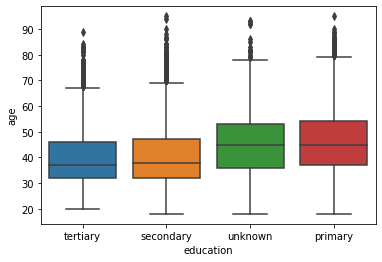

In [34]:
sns.boxplot(y="age", x="education", data= bank);

In [35]:
group1 = bank[bank["education"]=="primary"].age
group2 = bank[bank["education"]=="secondary"].age
group3 = bank[bank["education"]=="tertiary"].age
group4 = bank[bank["education"]=="unknown"].age

fvalue, pvalue = stats.f_oneway(group1, group2, group3, group4)
print(fvalue, pvalue)

731.7577454812724 0.0


In [37]:
f_statistic_T(group1,group2,group3,group4)

731.7577454812732

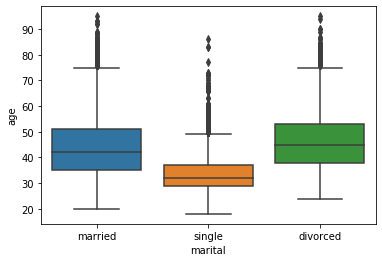

In [38]:
sns.boxplot(y="age", x="marital", data= bank);

In [39]:
group1 = bank[bank["marital"]=="single"].age
group2 = bank[bank["marital"]=="married"].age
group3 = bank[bank["marital"]=="divorced"].age


fvalue, pvalue = stats.f_oneway(group1, group2, group3)
print(fvalue, pvalue)

5228.732920484922 0.0


# Case 3: Categorical Input vs. Numerical Output

Actually this case is essentially the same as case 3, so we can use F-value.


# Case 4: Categorical Input vs. Categorical Output

When the input feature is categorical and the class is also categorical, the most common measures used are chi-square test and mutual information.


### Chi Square Test

As an example let us consider if there is a relationship between marital status and the class y for the banking dataset. Chi-square test relies on a contingency table. 

In [40]:
def calc_contingency_table_T(df, a1, a2):
    group1 = np.unique(df[a1])
    group2 = np.unique(df[a2])
    con_table = np.zeros((len(group1),len(group2)))
    for i in range(len(group1)):
        for j in range(len(group2)):
            con_table[i][j] = sum((df[a1] == group1[i]) & (df[a2] == group2[j]))
    return con_table, group1, group2

In [41]:
con_table,g1,g2 = calc_contingency_table_T(bank,"y","marital")
print(g1)
print(g2)

['no' 'yes']
['divorced' 'married' 'single']


In [42]:
con_table

array([[ 4585., 24459., 10878.],
       [  622.,  2755.,  1912.]])

In [43]:
stats.chi2_contingency(con_table)

(196.4959456560396,
 2.1450999986791486e-43,
 2,
 array([[ 4597.86012254, 24030.37552808, 11293.76434938],
        [  609.13987746,  3183.62447192,  1496.23565062]]))

In [45]:
def calc_chi2_contingency_T(con_table):
    con_table = con_table.astype(float)
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            expected = (marginals_row[i]) * (marginals_col[j]) / total
            con_table[i][j] = ((con_table[i][j] - expected)**2) / expected
    return con_table.sum()


In [46]:
chi2_stat = calc_chi2_contingency_T(con_table)
chi2_stat

196.4959456560396

In [47]:
le = LabelEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=np.object) # select string columns
X = X.apply(LabelEncoder().fit_transform)
y = le.fit_transform(bank.loc[:,'y'])
chi2, pval=feature_selection.chi2(X, y)


In [48]:
sorted_idx = np.argsort(chi2)[::-1]
sorted_vals = np.sort(chi2)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals, "p-values":pval[sorted_idx]}
df = pd.DataFrame(d)
df

,features,values,p-values
0,contact,1253.814109,1.230845e-274
1,housing,388.949715,1.401285e-86
2,job,182.452260,1.412576e-41
3,loan,176.516137,2.793375e-40
4,poutcome,104.677479,1.437254e-24
5,education,90.617723,1.742922e-21
6,month,44.321905,2.785815e-11
7,marital,29.766067,4.874498e-08
8,default,22.313875,2.315277e-06


### Mutual Information

#### Entropy

Given a discrete random variable $X$ with outcomes $\mathcal{X}=\{x_{1},...,x_{n}\}$ which occur with probability ${\displaystyle \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n})}$, the entropy of X is defined as:
$$
H(X) = -\sum_{x \in \mathcal{X}}P(x)logP(x)
$$

In [49]:
# pk[i] is the probability of outcome i
def entropy_T(pk):
    S = 0
    for i in range(len(pk)):
        if pk[i] > 0:
            S = S - pk[i]*np.log2(pk[i])
    return S

In [50]:
pk = [0.5, 0.5]
print("Entropy of a fair coin:", entropy_T(pk))
pk = [0.1, 0.9]
print("Entropy of a biased fair coin:", entropy_T(pk))
# Entropy of a fair dice
pk = [1/6,1/6,1/6,1/6,1/6,1/6]
print("Entropy of a fair dice:", entropy_T(pk))
pk = [2/6,2/6,0/6,0/6,2/6,0]
print("Entropy of a fair dice:", entropy_T(pk))

Entropy of a fair coin: 1.0
Entropy of a biased fair coin: 0.4689955935892812
Entropy of a fair dice: 2.584962500721156
Entropy of a fair dice: 1.584962500721156


Shape of the entropy function for a variable with two outcomes

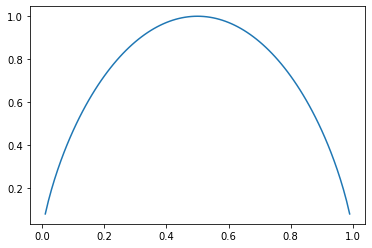

In [51]:
x = np.arange(0.01,1,0.01)
s = []
for i in x:
    s.append(entropy_T([i,1-i]))
plt.plot(x,s)

#### Some facts about entropy

- The range of Entropy:
    $0 ≤ Entropy ≤ log(n)$, where n is number of outcomes
- Minimum entropy ($0$) occurs when one of the probabilities is 1 and rest are 0’s.
- Maximum entropy ($log(n)$) occurs when all the probabilities are the same, namely, 1/n.

#### Mutual Information

$$
I(X;Y) = \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}P(x,y)log\frac{P(x,y)}{P(x)P(y)}
$$

where $P(X,Y)$ is the joint and $P(X)$ and $P(Y)$ are the marginal probability distributions of the random variables $X$ and $Y$.



In [55]:
def mutual_info_T(df, a1, a2):
    con_table, g1, g2 = calc_contingency_table_T(df, a1, a2)
    print(con_table)
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    mi = 0
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            # Calculate joint probability.
            p = con_table[i][j] / total
            m = (marginals_row[i] / total)*(marginals_col[j] / total)
            if (p > 0):
                mi += p*np.log(p / m)
    return mi

In [56]:
mutual_info_T(bank,"y","marital")

[[ 4585. 24459. 10878.]
 [  622.  2755.  1912.]]


0.0021012181142472646

In [64]:
X = bank.loc[:,['marital', 'education', 'y']]
X

,marital,education,y
0,married,tertiary,no
1,single,secondary,no
2,married,secondary,no
3,married,unknown,no
4,single,unknown,no
...,...,...,...
45206,married,tertiary,yes
45207,divorced,primary,yes
45208,married,secondary,yes
45209,married,secondary,no


In [65]:
X = X.apply(LabelEncoder().fit_transform)
X

,marital,education,y
0,1,2,0
1,2,1,0
2,1,1,0
3,1,3,0
4,2,3,0
...,...,...,...
45206,1,2,1
45207,0,0,1
45208,1,1,1
45209,1,1,0


In [66]:
importances_mi = mutual_info_classif(X.loc[:,['marital','education']], X.y,discrete_features=True)
importances_mi


array([0.00210122, 0.00259818])

In [102]:
le = LabelEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=np.object) # select string columns
X = X.apply(LabelEncoder().fit_transform)
y = le.fit_transform(bank.loc[:,'y'])
importances_mi=mutual_info_classif(X, y,discrete_features=True)


In [68]:
sorted_idx = np.argsort(importances_mi)[::-1]
sorted_vals = np.sort(importances_mi)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals}
df = pd.DataFrame(d)
df

,features,values
0,poutcome,0.029397
1,month,0.024351
2,contact,0.013627
3,housing,0.009654
4,job,0.008264
5,loan,0.002630
6,education,0.002598
7,marital,0.002101
8,default,0.000294


# Categorical (nominal), Ordinal, and Numerical Variables

You can read this link for the differences with these types of variables.

https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-numerical-variables/

### Be careful in using OrdinalEncoder
There is some confusion on the use of LabelEncoder and OrdinalEncoder in Pytgon. LabelEncoder is generally used to encode class variable, and OrdinalEncoder is generally used to encode feature en X. However, note that OrdinalEncoder cannot not assign integer based on the inherent order of the values, you have to give these mapping.

In [95]:
oe = OrdinalEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=np.object) # select string columns
oe.fit_transform(X)

array([[4., 1., 2., ..., 2., 8., 3.],
       [9., 2., 1., ..., 2., 8., 3.],
       [2., 1., 1., ..., 2., 8., 3.],
       ...,
       [5., 1., 1., ..., 0., 9., 2.],
       [1., 1., 1., ..., 1., 9., 3.],
       [2., 1., 1., ..., 0., 9., 1.]])

In [86]:
X.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [87]:
X.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [89]:
ordinal_map = {'tertiary':3, 'secondary':2, 'primary':1, 'unknown':0}

In [90]:
X

,job,marital,education,default,housing,loan,contact,month,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,unknown
1,technician,single,secondary,no,yes,no,unknown,may,unknown
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown
4,unknown,single,unknown,no,no,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,unknown
45207,retired,divorced,primary,no,no,no,cellular,nov,unknown
45208,retired,married,secondary,no,no,no,cellular,nov,success
45209,blue-collar,married,secondary,no,no,no,telephone,nov,unknown


If you want to give integer labels in the correct order for the feature education, you should do it manually.

In [104]:
X = bank.loc[:,'age':'poutcome']
X['education'] = X.education.map(ordinal_map)
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,3,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,2,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,2,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,0,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,0,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,3,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,1,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,2,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,2,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown
